**I think we can start here with preprocessing and building up a pipeline for classifying with a traditional model from pose estimation**

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Classes

- Walking
- Standing
- Fast walking / jogging?
- Running

# Import data from google drive

In [1]:
from google.colab import drive
import os

drive.mount("/content/drive", force_remount=True)

zip_path = '/content/drive/My Drive/hmdb51_stabalized.zip'

extract_path = "/content/hmdb51_data"

if not os.path.exists(extract_path):
    !unzip -q "{zip_path}" -d "{extract_path}"
else:
    print(f"The directory {extract_path} already exists.")

path = extract_path + "/hmdb51_stabalized"

Mounted at /content/drive
The directory /content/hmdb51_data already exists.


# Import libraries and set up configurations

In [2]:
import os
import cv2
import numpy as np
import gc # Garbage collector to free RAM manually

# --- CONFIGURATION ---
RAW_DATA_PATH = path
# SAVE TO DRIVE so you never have to do this again
SAVE_PATH = "/content/drive/My Drive/hmdb51_processed"
CLASSES = ["run", "jump", "walk", "stand"]
IMG_SIZE = 128
FRAME_COUNT = 16

# Load a process data with cv2 to extract frames

In [3]:
# Create save folder if not exists
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)

def process_video_uint8(path):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret: break
            frame = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
    finally:
        cap.release()

    if len(frames) == 0: return None

    # Even sampling
    indices = np.linspace(0, len(frames)-1, FRAME_COUNT, dtype=int)
    # KEEP AS UINT8 (Small size)
    return np.array([frames[i] for i in indices], dtype=np.uint8)

print(f" Starting processing. Saving to: {SAVE_PATH}")

 Starting processing. Saving to: /content/drive/My Drive/hmdb51_processed


In [5]:
for class_id, class_name in enumerate(CLASSES):
    print(f"\nProcessing class: '{class_name}'...")
    folder_path = os.path.join(RAW_DATA_PATH, class_name)

    class_videos = []
    class_labels = []

    if not os.path.exists(folder_path):
        print(f"Skipping {class_name} (folder missing)")
        continue

    files = [f for f in os.listdir(folder_path) if f.endswith('.avi')]

    for file_name in files:
        video_path = os.path.join(folder_path, file_name)
        video_data = process_video_uint8(video_path)

        if video_data is not None:
            class_videos.append(video_data)
            class_labels.append(class_id)

    # Convert to array and save IMMEDIATELY
    if len(class_videos) > 0:
        X_chunk = np.array(class_videos, dtype=np.uint8)
        y_chunk = np.array(class_labels, dtype=np.int32)

        # Save to Drive
        np.save(os.path.join(SAVE_PATH, f"X_{class_name}.npy"), X_chunk)
        np.save(os.path.join(SAVE_PATH, f"y_{class_name}.npy"), y_chunk)

        print(f" Saved {class_name}: {X_chunk.shape} samples")

    # FREE RAM
    del class_videos, class_labels, X_chunk, y_chunk
    gc.collect() # Force Python to release memory

print("\n All Processing Complete! Data is safely on Google Drive.")


Processing class: 'run'...
 Saved run: (232, 16, 128, 128, 3) samples

Processing class: 'jump'...
 Saved jump: (151, 16, 128, 128, 3) samples

Processing class: 'walk'...
 Saved walk: (548, 16, 128, 128, 3) samples

Processing class: 'stand'...
 Saved stand: (154, 16, 128, 128, 3) samples

 All Processing Complete! Data is safely on Google Drive.


# Train test split, but first loading from drive (I was havinng problems with RAM on colab otherwise)

In [4]:
import os
import numpy as np
from sklearn.model_selection import train_test_split

# Config
DATASET_PATH = path
CLASSES = ["run", "jump", "walk", "stand"]

# --- 1. GATHER PATHS (NOT PIXELS) ---
# We only store the text locations of the files. This is instant and lightweight.
all_video_paths = []
all_labels = []

print("Scanning for file paths...")
for class_id, class_name in enumerate(CLASSES):
    folder = os.path.join(DATASET_PATH, class_name)
    if not os.path.exists(folder):
        print(f"⚠️ Warning: Folder not found: {folder} (Did you forget to Unzip?)")
        continue

    # Find all .avi files
    files = [f for f in os.listdir(folder) if f.endswith('.avi')]
    for f in files:
        all_video_paths.append(os.path.join(folder, f))
        all_labels.append(class_id)

print(f" Found {len(all_video_paths)} videos.")

# --- 2. SPLIT THE PATHS ---
# We split the list of strings, not the heavy video data
train_paths, val_paths, train_labels, val_labels = train_test_split(
    all_video_paths, all_labels, test_size=0.2, stratify=all_labels, random_state=42
)

print(f"Train set: {len(train_paths)} paths")
print(f"Validation set: {len(val_paths)} paths")

Scanning for file paths...
 Found 1085 videos.
Train set: 868 paths
Validation set: 217 paths


# Model build (pre-trained efficientnet)

In [5]:
import tensorflow as tf
import cv2

class VideoGenerator(tf.keras.utils.Sequence):
    def __init__(self, paths, labels, batch_size=8, img_size=128, frame_count=16, shuffle=True):
        self.paths = paths
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.frame_count = frame_count
        self.shuffle = shuffle
        self.indices = np.arange(len(self.paths))
        self.on_epoch_end() # Initialize shuffle

    def __len__(self):
        # Number of batches per epoch
        return int(np.floor(len(self.paths) / self.batch_size))

    def __getitem__(self, index):
        # 1. Get the indices for this batch
        batch_indices = self.indices[index*self.batch_size : (index+1)*self.batch_size]

        # 2. Setup the empty batch arrays
        X = np.empty((self.batch_size, self.frame_count, self.img_size, self.img_size, 3), dtype=np.float32)
        y = np.empty((self.batch_size), dtype=np.int32)

        # 3. Fill the batch
        for i, idx in enumerate(batch_indices):
            # Read the video file (Disk -> RAM)
            video_path = self.paths[idx]
            frames = self._load_video(video_path)

            X[i] = frames
            y[i] = self.labels[idx]

        # 4. Preprocess for EfficientNet (Scaling)
        return tf.keras.applications.efficientnet.preprocess_input(X), y

    def _load_video(self, path):
        cap = cv2.VideoCapture(path)
        frames = []
        try:
            while True:
                ret, frame = cap.read()
                if not ret: break
                frame = cv2.resize(frame, (self.img_size, self.img_size))
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frames.append(frame)
        finally:
            cap.release()

        # Handle errors/empty videos
        if len(frames) == 0:
            return np.zeros((self.frame_count, self.img_size, self.img_size, 3), dtype=np.float32)

        # Even Sampling (16 frames)
        indices = np.linspace(0, len(frames)-1, self.frame_count, dtype=int)
        selected = np.array([frames[i] for i in indices])
        return selected

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

# Create the Generators
train_gen = VideoGenerator(train_paths, train_labels, batch_size=8)
val_gen = VideoGenerator(val_paths, val_labels, batch_size=8, shuffle=False)

In [10]:
from tensorflow.keras import layers, models, applications, optimizers

def build_advanced_model():
    video_input = layers.Input(shape=(16, 128, 128, 3))

    base_cnn = applications.EfficientNetB0(
        weights='imagenet', include_top=False, input_shape=(128, 128, 3)
    )

    # Unfreeze top 30 layers (slightly more freedom than 20)
    base_cnn.trainable = True
    for layer in base_cnn.layers[:-30]:
        layer.trainable = False

    # 2. Extract Features from every frame
    encoded = layers.TimeDistributed(base_cnn)(video_input)
    encoded = layers.TimeDistributed(layers.GlobalAveragePooling2D())(encoded)

    # Adding RNN layer
    x = layers.GRU(64, return_sequences=False)(encoded)
    x = layers.Dropout(0.5)(x)

    # 3. Output
    output = layers.Dense(len(CLASSES), activation='softmax')(x)

    model = models.Model(inputs=video_input, outputs=output)

    # We use a slightly lower learning rate because the GRU is sensitive
    model.compile(
        optimizer=optimizers.Adam(learning_rate=5e-5),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model = build_advanced_model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 16, 128, 128,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 16, 4, 4, 1280) │     4,049,571 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 16, 1280)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 64)             │       258,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,308,263 (16.43 MB)

 Trainable params: 1,754,852 (6.69 MB)

 Non-trainable params: 2,553,411 (9.74 MB)

# Train the model on our classes

In [11]:

drive.mount('/content/drive')

# This creates a folder "Models" in your Drive if it doesn't exist
save_folder = "/content/drive/MyDrive/Models"
os.makedirs(save_folder, exist_ok=True)
checkpoint_path = os.path.join(save_folder, "hmdb51_efficientnet_best.keras")

print(f" Model will be saved to: {checkpoint_path}")

# Define Callbacks
callbacks = [
    # Stop if validation loss doesn't improve for 4 epochs
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),

    # Save the model every time the validation loss improves
    ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        verbose=1 # Prints a message when saving
    )
]

# Train using the Generators
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=callbacks
)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Model will be saved to: /content/drive/MyDrive/Models/hmdb51_efficientnet_best.keras


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.3599 - loss: 1.4102
Epoch 1: val_loss improved from inf to 1.15302, saving model to /content/drive/MyDrive/Models/hmdb51_efficientnet_best.keras
108/108 ━━━━━━━━━━━━━━━━━━━━ 287s 988ms/step - accuracy: 0.3603 - loss: 1.4096 - val_accuracy: 0.5370 - val_loss: 1.1530
Epoch 2/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.5577 - loss: 1.1348
Epoch 2: val_loss improved from 1.15302 to 1.05421, saving model to /content/drive/MyDrive/Models/hmdb51_efficientnet_best.keras
108/108 ━━━━━━━━━━━━━━━━━━━━ 63s 588ms/step - accuracy: 0.5575 - loss: 1.1349 - val_accuracy: 0.5648 - val_loss: 1.0542
Epoch 3/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.5401 - loss: 1.0514
Epoch 3: val_loss improved from 1.05421 to 1.00874, saving model to /content/drive/MyDrive/Models/hmdb51_efficientnet_best.keras
108/108 ━━━━━━━━━━━━━━━━━━━━ 81s 578ms/step - accuracy: 0.5403 - loss: 1.0512 - val_accuracy: 0.6065 - val_loss:

# Save the model to google Drive

In [7]:
from google.colab import drive
drive.mount('/content/drive')

!mv /content/hmdb51_efficientnet.keras /content/drive/MyDrive/


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mv: cannot stat '/content/hmdb51_efficientnet.keras': No such file or directory


In [8]:
from tensorflow.keras.models import load_model
from google.colab import drive

drive.mount('/content/drive')
model = load_model("/content/drive/MyDrive/Models/hmdb51_efficientnet_best.keras")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Generating predictions...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


27/27 ━━━━━━━━━━━━━━━━━━━━ 103s 412ms/step
Predictions: (216,)
Ground Truth: (216,)


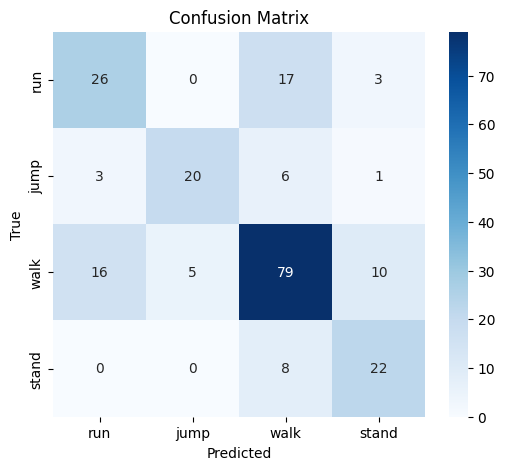


Classification Report:
              precision    recall  f1-score   support

         run       0.58      0.57      0.57        46
        jump       0.80      0.67      0.73        30
        walk       0.72      0.72      0.72       110
       stand       0.61      0.73      0.67        30

    accuracy                           0.68       216
   macro avg       0.68      0.67      0.67       216
weighted avg       0.68      0.68      0.68       216



In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


y_pred_prob = model.predict(val_gen, verbose=1)
y_pred = np.argmax(y_pred_prob, axis=1)


y_true = []
for i in range(len(val_gen)):
    _, batch_labels = val_gen[i]
    y_true.extend(batch_labels)

y_true = np.array(y_true)

# Sanity Check: These shapes MUST match
print(f"Predictions: {y_pred.shape}")
print(f"Ground Truth: {y_true.shape}")

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# 4. REPORT
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=CLASSES))
